In [ ]:
#Code pour supprimer un dossier et tout son contenu : attention à donner la bonne adresse !
#!rm -r "/content/chemin/vers/ton/dossier"

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import pickle
import sys
from PIL import Image
import glob

In [ ]:
# First we download the .zip file containing all the images
tf.keras.utils.get_file("/content/drive/MyDrive/A_rappers/rappers.zip",
                        origin="file:///C:/Users/bensi/Documents/Jedha/rappers.zip",
                        extract=False,
                        cache_subdir="/content/drive/MyDrive/A_rappers")

'/content/drive/MyDrive/A_rappers/rappers.zip'

In [ ]:
#Preparing path in order to label images
import os.path
data_dir = os.path.expanduser('/content/drive/MyDrive/A_rappers/rappers3/data')

train_data_dir = os.path.join(data_dir, 'train')
validation_data_dir = os.path.join(data_dir, 'val')

class_names = os.listdir(train_data_dir) # Get names of classes
class_names.sort()
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels
id_to_classname = { index: label for index, label in enumerate(class_names) }
# Persist this mapping so it can be loaded when training for decoding
with open(os.path.join(data_dir, 'class_name2id.p'), 'wb') as p:
    pickle.dump(class_name2id, p, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_generator = ImageDataGenerator(
    rotation_range=0, # Angle range for random image rotation
    width_shift_range=0.0, # Random shift of the image along width axis
    height_shift_range=0.0, # Random shift of the image along height axis
    brightness_range=(0.5,1), # Random brightness modification
    shear_range=0.0, # Random distortion of the image
    zoom_range=0.0, # Random zoom on the image
    channel_shift_range=50.0, # Random hue modification
    horizontal_flip=True, # Randomly flips image horizontally
    vertical_flip=True, # Randomly flips image virtically
    rescale=1/255., # Rescaling values from [0,255]->[0,1]
    fill_mode='wrap',
    validation_split=0.3 # Portion of the data that can be saved for validation
)

In [ ]:
directory_generator = img_generator.flow_from_directory(
    directory = "/content/drive/MyDrive/A_rappers/rappers3/data/train", # the folder where the class subfolders can be found
    target_size = (224,224), # The (height,width) of the produced images
    class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=16, # The batch size of the produced batches
    shuffle = True #Whether to shuffle after all files have been selected once
    #subset = "training"
)

directory_generator_val = img_generator.flow_from_directory(
    directory = "/content/drive/MyDrive/A_rappers/rappers3/data/val", # the folder where the class subfolders can be found
    target_size = (224,224), # The (height,width) of the produced images
    class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=16, # The batch size of the produced batches
    shuffle = True #Whether to shuffle after all files have been selected once
    #subset = "validation"
)

Found 1705 images belonging to 36 classes.
Found 1705 images belonging to 36 classes.


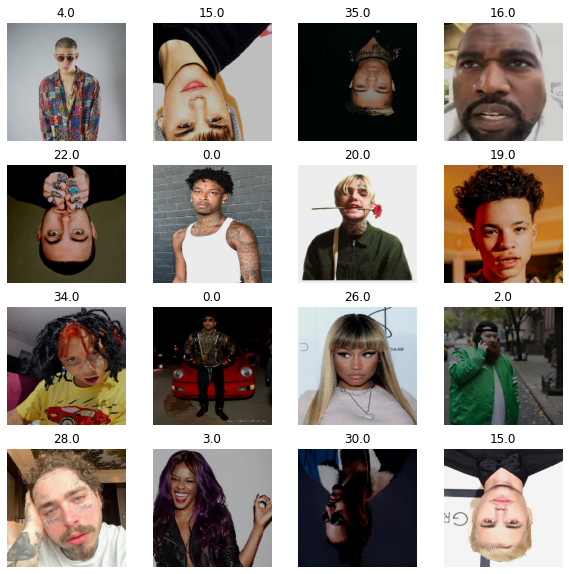

In [ ]:
imgs, targets = next(iter(directory_generator))
fig, ax = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(imgs[i*4+j])
    ax[i,j].title.set_text(str(targets[i*4+j]))
    ax[i, j].axis('off')
fig.show()

In [ ]:
#Importing a pretrained model from tensorflow
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
#Set the weights of your imported model as non-trainable 
base_model.trainable = False

In [ ]:
#Creating a complete model by adding the last layer as a softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(36, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                294948    
Total params: 22,097,732
Trainable params: 294,948
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
#Compile, optimize and loss
from tensorflow.keras.models import Sequential
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
#Training the model and monitor the overfitting using the validation data.
#Using 30 epochs in order to monitor the process precisely.
model.fit(directory_generator, epochs=30, validation_data=directory_generator_val)

Epoch 1/30
107/107 [==============================] - 1347s 12s/step - loss: 7.9693 - sparse_categorical_accuracy: 0.1003 - val_loss: 4.9755 - val_sparse_categorical_accuracy: 0.2956
Epoch 2/30
107/107 [==============================] - 39s 369ms/step - loss: 4.5561 - sparse_categorical_accuracy: 0.3167 - val_loss: 4.2062 - val_sparse_categorical_accuracy: 0.4229
Epoch 3/30
107/107 [==============================] - 39s 363ms/step - loss: 3.6822 - sparse_categorical_accuracy: 0.4106 - val_loss: 2.6380 - val_sparse_categorical_accuracy: 0.5044
Epoch 4/30
107/107 [==============================] - 39s 362ms/step - loss: 3.0192 - sparse_categorical_accuracy: 0.4891 - val_loss: 3.3990 - val_sparse_categorical_accuracy: 0.5026
Epoch 5/30
107/107 [==============================] - 39s 361ms/step - loss: 2.7963 - sparse_categorical_accuracy: 0.5496 - val_loss: 2.8636 - val_sparse_categorical_accuracy: 0.5554
Epoch 6/30
107/107 [==============================] - 38s 360ms/step - loss: 2.4993 -

In [ ]:
!pip install h5py -q

In [ ]:
#Saving the model as an HDF5 file for future prediction
from keras.models import model_from_json
import json
model.save('rappers3.h5')
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/rappers3.json", 'w'))

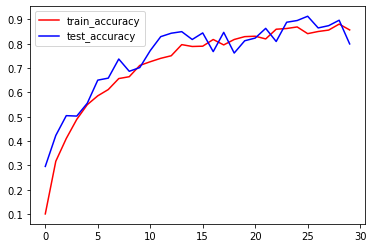

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["sparse_categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_sparse_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Re-instantiated model
from keras.models import load_model
from keras.preprocessing import image
loaded_model = tf.keras.models.load_model('rappers3.h5')
loaded_model.layers[0].input_shape #(None, 224, 224, 3)

(None, 224, 224, 3)

In [ ]:
#PNG to JPG converter package
!pip install Pillow -q

In [ ]:
#Convert PNG to jpg
#from PIL import Image

#im1 = Image.open(r'/content/jrmy.PNG')
#im1.save(r'/content/jrmy.jpg')


In [ ]:
# load image as pixel array
from matplotlib import image
from matplotlib import pyplot
img = image.imread('aab.jpg')

In [ ]:
#Adding channel dimensions and normalizing by diving by 255
if len(img.shape) < 3:
  img = np.expand_dims(img, -1)
img = img/255.
print(img.shape)

(640, 640, 3)


In [ ]:
#Converting from greyscale (1 channels) to RGB (3) and resizing the model
#img = tf.image.grayscale_to_rgb(tf.image.resize(img, (224,224)))
img = tf.image.resize(img, (224,224))

In [ ]:
#Making predictions array on pictures
pred = model.predict(np.expand_dims(img, 0))
pred

array([[6.4149520e-37, 6.3358295e-25, 6.1906127e-12, 4.4587045e-03,
        2.9718313e-26, 8.4478506e-06, 8.4278705e-03, 6.7639077e-14,
        1.1591220e-16, 8.8307959e-01, 1.0307928e-03, 1.1917300e-14,
        1.1037081e-14, 9.0422077e-17, 1.9948903e-17, 7.0128182e-04,
        6.1553411e-26, 1.7705082e-07, 6.9992650e-14, 6.9473810e-10,
        8.2180966e-15, 2.9453442e-10, 8.1264249e-12, 3.9186103e-17,
        2.5389346e-21, 1.4567961e-12, 9.9543720e-02, 1.2659888e-11,
        5.1782784e-18, 1.7461261e-08, 2.3184504e-18, 5.7493005e-05,
        2.6918834e-03, 2.7150677e-09, 2.2379874e-14, 2.9745859e-12]],
      dtype=float32)

In [ ]:
#Returning the highest value from the array
np.argmax(pred)
id_to_classname[np.argmax(pred)]

'Doja cat'

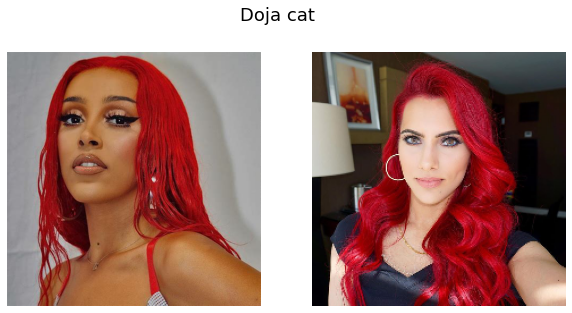

In [ ]:
#Converting from an array into a single class prediction
path = "/content/drive/MyDrive/A_rappers/rappers3/data/train" + "/" + id_to_classname[np.argmax(pred)] + "/" 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[1].imshow(img)
ax[0].imshow(image.imread(path + os.listdir(path)[0]))
ax[0].axis('off')
ax[1].axis('off')
fig.suptitle(id_to_classname[np.argmax(pred)], fontsize=18)
fig.show()

In [ ]:
#-----------------------

In [ ]:
#ressources
#id_to_classname[14]
#np.max(pred)
#print(pred)

In [ ]:
class_names